In [1]:
%matplotlib inline
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import pandas as pd
from sctools import integrate, plot, io

Global seed set to 0


# Annotate celltypes with celltypist

In [2]:
adata = sc.read_h5ad(
    '../data/tissue.scps.integrated.clustered.h5ad'
)
adata

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 332546 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types'

In [ ]:
resolution = 0.4
sc.tl.leiden(
    adata, 
    key_added = f'leiden_scvi_{resolution}',
    resolution = resolution
)

In [ ]:
sc.pl.umap(
    adata,
    color = f'leiden_scvi_{resolution}'
)

In [ ]:
obs = adata.obs.copy()
var = adata.raw.var.copy()
bdata = ad.AnnData(
    X = adata.raw.X,
    obs = obs,
    var = var,
    dtype = np.int64
)

In [3]:
sc.pp.normalize_total(
    bdata,
    target_sum = 1e4
)
sc.pp.log1p(bdata)

In [ ]:
# needs to be clustered again 0.1 is too coa

In [4]:
import celltypist as ct
model = ct.models.Model.load(model = 'Adult_Human_Skin.pkl')
model

CellTypist model with 34 cell types and 3295 features
    date: 2023-09-22 18:13:10.902604
    details: cell types from human healthy adult skin
    source: https://doi.org/10.1126/science.aba6500
    version: v1
    cell types: DC1, DC2, ..., moDC
    features: ISG15, TNFRSF18, ..., MT-CYB

In [5]:
predictions = ct.annotate(
    bdata, 
    model = 'Adult_Human_Skin.pkl', 
    majority_voting = True,
    over_clustering = 'leiden_scvi_0.1'
)

🔬 Input data has 332546 cells and 20912 genes
🔗 Matching reference genes in the model
🧬 3295 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [7]:
cdata = predictions.to_adata()

In [12]:
adata.obs['cell_type'] = cdata.obs.majority_voting

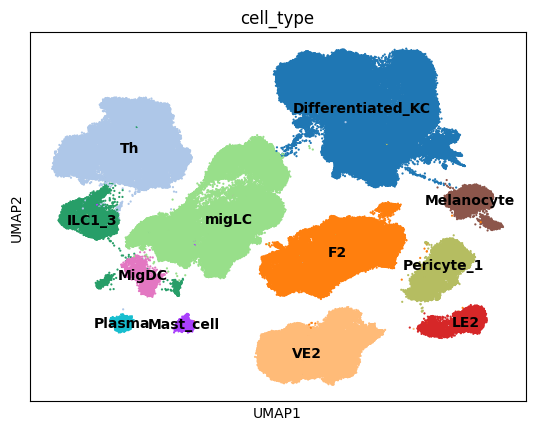

In [16]:
%matplotlib inline
sc.pl.umap(
    adata,
    color = 'cell_type',
    legend_loc = 'on data',
    size = 10
)

In [4]:
adata.write('../data/tissue.scps.integrated.annotated.coarse.h5ad')

In [ ]:
io.write_sc_data(
    adata,
    '../cellchat/tissue.scps',
    obs_columns = ['sample_id', 'status', 'tissue', 'cell_type']
)